<a href="https://colab.research.google.com/github/aaron020/CNN_Project/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#https://github.com/pythonlessons/Keras-ResNet-tutorial/blob/master/Keras-ResNet-tutorial.ipynb

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib import pyplot as plt
import keras.backend as K
import tensorflow as tf

In [24]:
#Rows and cols = the size of the image, channels = RGB and classes is dog and cat 
ROWS = 224
COLS = 224
CHANNELS = 3
CLASSES = 2

In [25]:
#!unzip drive/MyDrive/archive.zip


#from google.colab import drive
#drive.mount('/content/drive')

In [26]:
#pull in a dataset from content 
pathNameTraining = "training_set/training_set"
pathNameTest = "test_set/test_set"

#!unzip archive.zip
Training_types = os.listdir(pathNameTraining)
test_types = os.listdir(pathNameTest)

print("Training folders = " , Training_types)
print("Test folders = " , test_types)

Training folders =  ['cats', 'dogs']
Test folders =  ['cats', 'dogs']


In [27]:

def read_image(file_path):
    #Read in the image, in colour 
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    #Return the image, resized to be 224 x 224   
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prepare_data(images):
    m = len(images)
    X = np.zeros((m, ROWS, COLS, CHANNELS), dtype=np.uint8)
    y = np.zeros((1, m), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = read_image(image_file)
        if 'dogs' in image_file.lower():
            y[0, i] = 1
        elif 'cats' in image_file.lower():
            y[0, i] = 0
    return X, y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y



In [28]:
#Tack all the data from the datset 
TRAIN_DIR = []
TEST_DIR = []

for item in Training_types:
  # get all the files from each folder 
  all_training = os.listdir(pathNameTraining + '/' + item)
  #Half the dataset due to ram problems
  for fw in range(0,1000):
    #Some of the training set is not jpg which causes errors for the resize
    if 'jpg' in all_training[fw]:
      name = pathNameTraining + '/' + item + '/' + all_training[fw]
      TRAIN_DIR.append(name)


for item in test_types:
  # get all the files from each folder 
  all_test = os.listdir(pathNameTest + '/' + item)
  #Half the dataset due to ram problems
  for fw in range(0,500):
    if 'jpg' in all_test[fw]:
      name = pathNameTest + '/' + item + '/' + all_test[fw]
      TEST_DIR.append(name)


print(len(TRAIN_DIR))
print(len(TEST_DIR))


1998
998


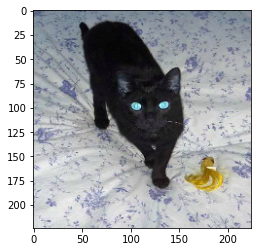

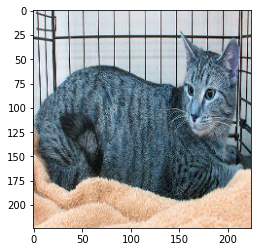

In [29]:
train_set_x, train_set_y = prepare_data(TRAIN_DIR)
test_set_x, test_set_y = prepare_data(TEST_DIR)


Y_train = convert_to_one_hot(train_set_y, CLASSES).T
Y_test = convert_to_one_hot(test_set_y, CLASSES).T



for sample in train_set_x[:2]:
  plt.imshow(sample)
  plt.show()

In [30]:
X_train = train_set_x/255
X_test = test_set_x/255


In [31]:
print(len(train_set_y[0]))

1998


In [32]:
print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

number of training examples = 1998
number of test examples = 998
X_train shape: (1998, 224, 224, 3)
Y_train shape: (1998, 2)
X_test shape: (998, 224, 224, 3)
Y_test shape: (998, 2)


In [33]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [34]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [35]:
def ResNet50(input_shape = (224, 224, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model



In [36]:
model = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
#For example: validation_split=0.3 will cause that 30% of the training data will be used for validation.
history = model.fit(X_train, Y_train, epochs = 50, validation_split=0.2,batch_size = 32)

Epoch 1/50
50/50 [==============================] - 35s 397ms/step - loss: 2.8592 - accuracy: 0.5670 - val_loss: 0.5065 - val_accuracy: 1.0000
Epoch 2/50
50/50 [==============================] - 16s 330ms/step - loss: 1.9125 - accuracy: 0.5738 - val_loss: 0.5907 - val_accuracy: 1.0000
Epoch 3/50
50/50 [==============================] - 17s 332ms/step - loss: 1.1831 - accuracy: 0.5882 - val_loss: 0.7536 - val_accuracy: 0.3800
Epoch 4/50
50/50 [==============================] - 17s 339ms/step - loss: 0.7760 - accuracy: 0.6133 - val_loss: 1.8216 - val_accuracy: 0.0025
Epoch 5/50
50/50 [==============================] - 17s 345ms/step - loss: 0.6236 - accuracy: 0.7109 - val_loss: 0.8524 - val_accuracy: 0.4550
Epoch 6/50
50/50 [==============================] - 17s 344ms/step - loss: 0.6309 - accuracy: 0.6984 - val_loss: 2.1110 - val_accuracy: 0.0500
Epoch 7/50
50/50 [==============================] - 17s 344ms/step - loss: 0.5541 - accuracy: 0.7390 - val_loss: 1.8924 - val_accuracy: 0.1650

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))